In [1]:
import os
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style 
import seaborn as sns
style.use("ggplot")
from textwrap import wrap
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import Counter
import string
import nltk
from nltk.corpus import wordnet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, log_loss
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D # type: ignore
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
df = pd.read_csv('AI_Human.csv')

In [3]:
print(df.shape)
df0_text = df[df['generated'] == 0].copy()
df1_ai = df[df['generated'] == 1].copy()
df0_text= df0_text[:10000]
df1_ai= df1_ai[:10000]

(487235, 2)


In [4]:
df = pd.concat([df0_text,df1_ai], ignore_index=True) 
print(df.shape)
df

(20000, 2)


,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
19995,The use of renewable energy sources is an impo...,1.0
19996,High school sports are often a source of pride...,1.0
19997,The beauty of nature can be seen in the cycle ...,1.0
19998,The impact of air pollution on human health is...,1.0


In [5]:
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))
linking_words = {'to', 'the', 'and', 'of', 'in', 'on', 'for', 'with', 'at', 'a', 'an'}

# Initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to count the length of each text and perform sentiment analysis
def analyze_text(text):
    # Tokenize the text and filter out the stopwords and linking words
    tokens = word_tokenize(text.lower()) # Tokenize the lowercase text
    tokens = [token for token in tokens if token not in stop_words and token not in linking_words] # Remove stopwords and linking words
    tokens = [token for token in tokens if token.isalpha()] # Remove punctuation
    # Sentiment analysis
    sentiment_scores = sid.polarity_scores(text) # Get sentiment scores  -1 to 1, -1 for negative, 0 for neutral, and 1  positive
    return len(tokens), sentiment_scores['compound'] # Return the length of the text and the sentiment score

df0_text[['text_length', 'sentiment_score']] = df0_text['text'].apply(lambda x: pd.Series(analyze_text(x)))
df1_ai[['text_length', 'sentiment_score']] = df1_ai['text'].apply(lambda x: pd.Series(analyze_text(x)))

In [6]:
def count_punctuation_marks(text):
    punctuation_count = sum(1 for char in text if char in string.punctuation)
    return punctuation_count

def count_linking_words(text):
    linking_words_count = sum(1 for word in word_tokenize(text.lower()) if word in linking_words)
    return linking_words_count
    
df0_text['punctuation_count'] = df0_text['text'].apply(count_punctuation_marks)
df1_ai['punctuation_count'] = df1_ai['text'].apply(count_punctuation_marks)

df0_text['linking_words_count'] = df0_text['text'].apply(count_linking_words)
df1_ai['linking_words_count'] = df1_ai['text'].apply(count_linking_words)

df = pd.concat([df0_text,df1_ai], ignore_index=False)
df

,text,generated,text_length,sentiment_score,punctuation_count,linking_words_count
0,Cars. Cars have been around since they became ...,0.0,315.0,0.9643,75,131
1,Transportation is a large necessity in most co...,0.0,257.0,-0.2426,64,108
2,"""America's love affair with it's vehicles seem...",0.0,408.0,0.9909,101,162
3,How often do you ride in a car? Do you drive a...,0.0,364.0,0.9902,124,133
4,Cars are a wonderful thing. They are perhaps o...,0.0,462.0,-0.9005,110,155
...,...,...,...,...,...,...
26090,The use of renewable energy sources is an impo...,1.0,190.0,0.9910,20,44
26091,High school sports are often a source of pride...,1.0,192.0,0.9969,24,46
26092,The beauty of nature can be seen in the cycle ...,1.0,212.0,0.9961,26,42
26093,The impact of air pollution on human health is...,1.0,228.0,0.7296,26,47


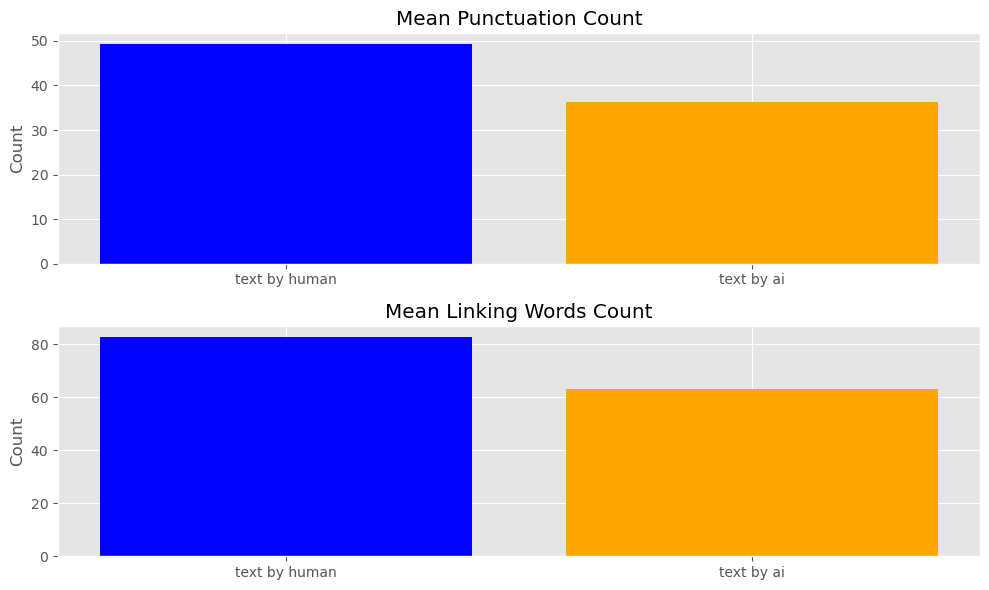

,text,generated,text_length,sentiment_score,punctuation_count,linking_words_count
0,Cars. Cars have been around since they became ...,0.0,315.0,0.9643,75,131
1,Transportation is a large necessity in most co...,0.0,257.0,-0.2426,64,108
2,"""America's love affair with it's vehicles seem...",0.0,408.0,0.9909,101,162
3,How often do you ride in a car? Do you drive a...,0.0,364.0,0.9902,124,133
4,Cars are a wonderful thing. They are perhaps o...,0.0,462.0,-0.9005,110,155
...,...,...,...,...,...,...
26090,The use of renewable energy sources is an impo...,1.0,190.0,0.9910,20,44
26091,High school sports are often a source of pride...,1.0,192.0,0.9969,24,46
26092,The beauty of nature can be seen in the cycle ...,1.0,212.0,0.9961,26,42
26093,The impact of air pollution on human health is...,1.0,228.0,0.7296,26,47


In [7]:
# Calculate the mean punctuation count and linking words count for the first 100000 texts
first_10000_mean_punctuation = df.iloc[:10000]['punctuation_count'].mean()
first_10000_mean_linking_words = df.iloc[:10000]['linking_words_count'].mean()

# Calculate the mean punctuation count and linking words count for the next 10000 texts
next_10000_mean_punctuation = df.iloc[10000:20000]['punctuation_count'].mean()
next_10000_mean_linking_words = df.iloc[10000:20000]['linking_words_count'].mean()


plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.bar(['text by human', 'text by ai'], [first_10000_mean_punctuation, next_10000_mean_punctuation], color=['blue', 'orange'])
plt.title('Mean Punctuation Count')
plt.ylabel('Count')


plt.subplot(2, 1, 2)
plt.bar(['text by human', 'text by ai'], [first_10000_mean_linking_words, next_10000_mean_linking_words], color=['blue', 'orange'])
plt.title('Mean Linking Words Count')
plt.ylabel('Count')

plt.tight_layout()
plt.show()
df

In [8]:
# Make a duplicate of the DataFrame
df_copy = df.copy()

# Remove the columns text_length and sentiment_score because they didnt help for our model
df_copy.drop(['text_length', 'sentiment_score'], axis=1, inplace=True) # Drop the text_length and sentiment_score columns
print(df_copy.head()) # Print the first 5 rows of the DataFrame
df_copy.fillna(0, inplace=True) # Fill missing values with 0

# Verify the changes
df_copy

                                                text  generated  \
0  Cars. Cars have been around since they became ...        0.0   
1  Transportation is a large necessity in most co...        0.0   
2  "America's love affair with it's vehicles seem...        0.0   
3  How often do you ride in a car? Do you drive a...        0.0   
4  Cars are a wonderful thing. They are perhaps o...        0.0   

   punctuation_count  linking_words_count  
0                 75                  131  
1                 64                  108  
2                101                  162  
3                124                  133  
4                110                  155  


,text,generated,punctuation_count,linking_words_count
0,Cars. Cars have been around since they became ...,0.0,75,131
1,Transportation is a large necessity in most co...,0.0,64,108
2,"""America's love affair with it's vehicles seem...",0.0,101,162
3,How often do you ride in a car? Do you drive a...,0.0,124,133
4,Cars are a wonderful thing. They are perhaps o...,0.0,110,155
...,...,...,...,...
26090,The use of renewable energy sources is an impo...,1.0,20,44
26091,High school sports are often a source of pride...,1.0,24,46
26092,The beauty of nature can be seen in the cycle ...,1.0,26,42
26093,The impact of air pollution on human health is...,1.0,26,47


In [9]:
def clean_text(text):
    cleaning_pattern = r'[^a-zA-Z\s]'

    clean_text = re.sub(cleaning_pattern, '', text)

    clean_text = clean_text.replace('\n', ' ')

    clean_text = re.sub(r'\s+', ' ', clean_text)

    return clean_text.strip()
df_copy['text'] = df_copy['text'].apply(clean_text)

# Function to tokenize text and remove stopwords
def tokenize_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token.isalpha() and token not in stop_words] # Return only alphabetic tokens that are not stopwords

# Tokenize all texts and count word occurrences
all_words = [word for text in df_copy['text'] for word in tokenize_text(text)] # Tokenize all texts and flatten the list
word_counts = Counter(all_words) # Count the occurrences of each word in all of the texts in the DataFrame


# Select the top 500 most common words as features
top_words = [word for word, _ in word_counts.most_common(500)]

# Function to create binary features for the top words
def create_word_features(text):
    tokens = tokenize_text(text)
    return [(1 if word in tokens else 0) for word in top_words]

def lengthText(text):
    tokens = word_tokenize(text.lower())
    return len(tokens)
    
df_copy['length_text'] = df_copy['text'].apply(lengthText)
# Create binary features for the top words in each text
df_copy['word_features'] = df_copy['text'].apply(create_word_features)
df_copy


,text,generated,punctuation_count,linking_words_count,length_text,word_features
0,Cars Cars have been around since they became f...,0.0,75,131,580,"[1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, ..."
1,Transportation is a large necessity in most co...,0.0,64,108,456,"[0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, ..."
2,Americas love affair with its vehicles seems t...,0.0,101,162,742,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, ..."
3,How often do you ride in a car Do you drive a ...,0.0,124,133,685,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
4,Cars are a wonderful thing They are perhaps on...,0.0,110,155,859,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, ..."
...,...,...,...,...,...,...
26090,The use of renewable energy sources is an impo...,1.0,20,44,298,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
26091,High school sports are often a source of pride...,1.0,24,46,327,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ..."
26092,The beauty of nature can be seen in the cycle ...,1.0,26,42,329,"[1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, ..."
26093,The impact of air pollution on human health is...,1.0,26,47,349,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, ..."


In [10]:
def create_word_features(text):
    tokens = tokenize_text(text)
    print(top_words)
    print(tokens)
    return [(1 if word in tokens else 0) for word in top_words]
print(create_word_features(df_copy['text'][0]))

print(df_copy['text'][0])

['people', 'car', 'would', 'also', 'venus', 'cars', 'could', 'one', 'many', 'driving', 'students', 'electoral', 'like', 'states', 'college', 'use', 'help', 'face', 'may', 'make', 'life', 'even', 'time', 'new', 'way', 'technology', 'us', 'get', 'system', 'world', 'usage', 'think', 'vote', 'important', 'better', 'planet', 'mars', 'phone', 'take', 'believe', 'able', 'day', 'need', 'example', 'author', 'know', 'much', 'less', 'earth', 'work', 'using', 'good', 'dont', 'around', 'air', 'different', 'without', 'things', 'limiting', 'see', 'another', 'pollution', 'transportation', 'well', 'however', 'president', 'popular', 'phones', 'conclusion', 'emotions', 'education', 'percent', 'student', 'made', 'computer', 'learn', 'cell', 'lead', 'something', 'school', 'want', 'facial', 'go', 'human', 'first', 'become', 'used', 'often', 'making', 'smog', 'environment', 'still', 'due', 'article', 'person', 'nasa', 'might', 'others', 'public', 'idea', 'really', 'reason', 'learning', 'gas', 'election', 'ch

In [11]:
word_counts.most_common(500)

[('people', 43324),
 ('car', 27132),
 ('would', 25735),
 ('also', 23765),
 ('venus', 23377),
 ('cars', 23239),
 ('could', 20946),
 ('one', 19635),
 ('many', 19574),
 ('driving', 19511),
 ('students', 18741),
 ('electoral', 18646),
 ('like', 18513),
 ('states', 17656),
 ('college', 16720),
 ('use', 16430),
 ('help', 16305),
 ('face', 16263),
 ('may', 15826),
 ('make', 14483),
 ('life', 14461),
 ('even', 14369),
 ('time', 13880),
 ('new', 12576),
 ('way', 12324),
 ('technology', 12173),
 ('us', 12015),
 ('get', 11845),
 ('system', 11648),
 ('world', 11448),
 ('usage', 11034),
 ('think', 10823),
 ('vote', 10406),
 ('important', 10305),
 ('better', 9905),
 ('planet', 9588),
 ('mars', 9057),
 ('phone', 8917),
 ('take', 8832),
 ('believe', 8828),
 ('able', 8793),
 ('day', 8674),
 ('need', 8653),
 ('example', 8462),
 ('author', 8360),
 ('know', 8309),
 ('much', 8259),
 ('less', 8171),
 ('earth', 8148),
 ('work', 7978),
 ('using', 7943),
 ('good', 7871),
 ('dont', 7762),
 ('around', 7733),
 ('

In [12]:
# Function to calculate percentage of punctuation marks in a text
def calculate_punctuation_count(text):
    if len(word_tokenize(text)) == 0:
        return 0
    return count_punctuation_marks(text) / len(word_tokenize(text)) * 100

df_copy['punctuation_count_percentage'] = df_copy['text'].apply(calculate_punctuation_count)

# Function to calculate percentage of linking words in a text
def calculate_linking_words_count(text):
    if len(word_tokenize(text)) == 0:
        return 0
    return count_linking_words(text) / len(word_tokenize(text)) * 100

# Add a column to the DataFrame for the linking words
df_copy['linking_words_percentage'] = df_copy['text'].apply(calculate_linking_words_count)

In [13]:
df_copy

,text,generated,punctuation_count,linking_words_count,length_text,word_features,punctuation_count_percentage,linking_words_percentage
0,Cars Cars have been around since they became f...,0.0,75,131,580,"[1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...",0.0,22.413793
1,Transportation is a large necessity in most co...,0.0,64,108,456,"[0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...",0.0,23.684211
2,Americas love affair with its vehicles seems t...,0.0,101,162,742,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, ...",0.0,21.832884
3,How often do you ride in a car Do you drive a ...,0.0,124,133,685,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...",0.0,19.416058
4,Cars are a wonderful thing They are perhaps on...,0.0,110,155,859,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, ...",0.0,18.044237
...,...,...,...,...,...,...,...,...
26090,The use of renewable energy sources is an impo...,1.0,20,44,298,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,14.765101
26091,High school sports are often a source of pride...,1.0,24,46,327,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...",0.0,14.067278
26092,The beauty of nature can be seen in the cycle ...,1.0,26,42,329,"[1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, ...",0.0,12.765957
26093,The impact of air pollution on human health is...,1.0,26,47,349,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",0.0,13.467049


Accuracy: 0.9975
Train Loss: 0.0036125957622006838
Test Loss: 0.007798517138656391
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3017
         1.0       1.00      1.00      1.00      2983

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Class-wise Metrics:
              precision    recall  f1-score    support
0.0            0.998009  0.997017  0.997513  3017.0000
1.0            0.996986  0.997989  0.997487  2983.0000
accuracy       0.997500  0.997500  0.997500     0.9975
macro avg      0.997498  0.997503  0.997500  6000.0000
weighted avg   0.997501  0.997500  0.997500  6000.0000


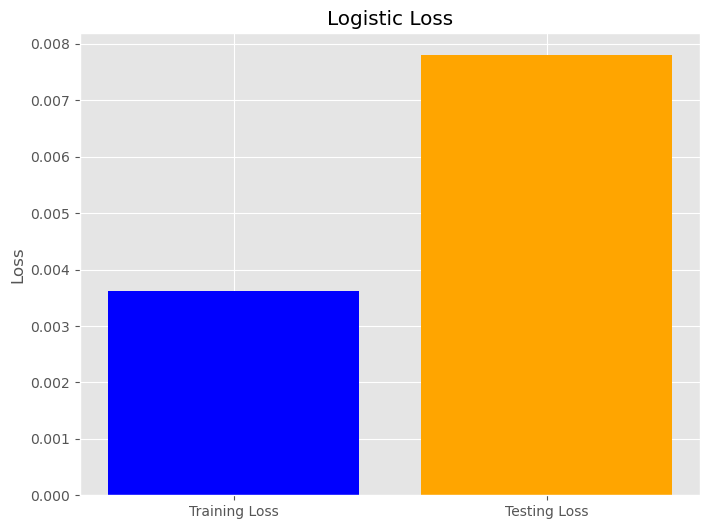

In [14]:
# Define features (word features, punctuation count, count of synonyms) and target variable
X = pd.DataFrame(df_copy['word_features'].tolist(), columns=top_words)
X['punctuation_count_percentage'] = df_copy['punctuation_count_percentage']
X['linking_words_percentage'] = df_copy['linking_words_percentage']
X['length_text'] = df_copy['length_text']
y = df_copy['generated']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize SimpleImputer, Fit and transform the imputer on the feature matrix X, Initialize and train the Logistic Regression classifier
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
model = LogisticRegression(max_iter=2000, random_state=42)
model.fit(X_train_imputed, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_imputed)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
train_loss = log_loss(y_train, model.predict_proba(X_train_imputed)) # Calculate logistic loss for training and testing sets
test_loss = log_loss(y_test, model.predict_proba(X_test_imputed))
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

# Calculate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Parse the classification report to get individual class metrics
class_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
print("Class-wise Metrics:")
print(class_report_df)

# Plotting the Loss
loss_values = [train_loss, test_loss]
labels = ['Training Loss', 'Testing Loss']

plt.figure(figsize=(8, 6))
plt.bar(labels, loss_values, color=['blue', 'orange'])
plt.title('Logistic Loss')
plt.ylabel('Loss')
plt.show()

In [15]:
# Define features (word features, punctuation count, count of synonyms) and target variable
X = pd.DataFrame(df_copy['word_features'].tolist(), columns=top_words)
X['punctuation_count_percentage'] = df_copy['punctuation_count_percentage']
X['linking_words_percentage'] = df_copy['linking_words_percentage']
X['length_text'] = df_copy['length_text']
y = df_copy['generated']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize SimpleImputer, Fit and transform the imputer on the feature matrix X
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train_imputed, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_imputed)
y_train_pred = model.predict(X_train_imputed)

# Convert predictions to binary labels (0 or 1)
y_pred_binary_train = [1 if pred >= 0.5 else 0 for pred in y_train_pred]
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_binary_train) 
print("Train Accuracy:", train_accuracy)
test_accuracy = accuracy_score(y_test, y_pred_binary)
print("Test Accuracy:", accuracy)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate classification report
class_report = classification_report(y_test, y_pred_binary)
print("Classification Report:")
print(class_report)


Train Accuracy: 0.9954285714285714
Test Accuracy: 0.9975
Mean Squared Error: 0.02586627438424262
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3017
         1.0       1.00      0.99      1.00      2983

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [16]:
# # Define features (word features, punctuation count, count of synonyms) and target variable
# X = pd.DataFrame(df_copy['word_features'].tolist(), columns=top_words)
# X['punctuation_count_percentage'] = df_copy['punctuation_count_percentage']
# X['linking_words_percentage'] = df_copy['linking_words_percentage']
# X['length_text'] = df_copy['length_text']
# y = df_copy['generated']

# # Split the data into training and testing sets
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

# # Initialize SimpleImputer
# imputer = SimpleImputer(strategy='constant', fill_value=0)

# # Fit and transform the imputer on the feature matrix X_train
# X_train_imputed = imputer.fit_transform(X_train)
# X_valid_imputed = imputer.transform(X_valid)  # Impute validation data, do not fit again

# # Reshape input data to fit CNN model
# X_train_cnn = X_train_imputed.reshape(X_train_imputed.shape[0], X_train_imputed.shape[1], 1)
# X_valid_cnn = X_valid_imputed.reshape(X_valid_imputed.shape[0], X_valid_imputed.shape[1], 1)

# # Define CNN model
# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# # Compile CNN model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train CNN model
# history = model.fit(X_train_cnn, y_train, epochs=30, batch_size=32, validation_data=(X_valid_cnn, y_valid))

# # Evaluate CNN model
# y_train_pred_probs = model.predict(X_train_cnn)
# y_valid_pred_probs = model.predict(X_valid_cnn)

# # Convert probabilities to class predictions using a threshold (e.g., 0.5)
# y_train_pred = (y_train_pred_probs > 0.5).astype(int)
# y_valid_pred = (y_valid_pred_probs > 0.5).astype(int)

# # Calculate train error
# train_error = 1 - accuracy_score(y_train, y_train_pred)

# # Calculate validation error
# validation_error = 1 - accuracy_score(y_valid, y_valid_pred)

# print("Train Error:", train_error)
# print("Validation Error:", validation_error)

# # Plot training history
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [17]:
X_test_cnn = X_test_imputed.reshape(X_test_imputed.shape[0], X_test_imputed.shape[1], 1)
y_test_pred_prob = model.predict(X_test_cnn)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", accuracy)

class_report = classification_report(y_test, y_test_pred)
print("Classification Report:")
print(class_report)
class_report_df = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True)).transpose()
print("Class-wise Metrics:")
print(class_report_df)

ValueError: Found array with dim 3. LinearRegression expected <= 2.

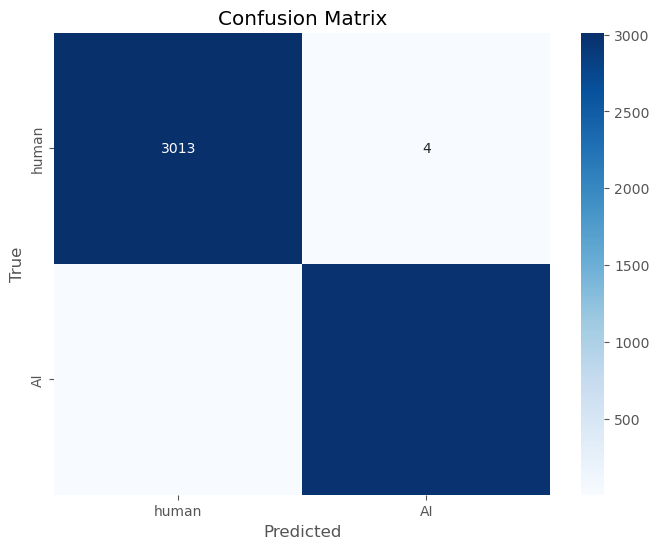

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['human', 'AI'], yticklabels=['human', 'AI'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()